In [43]:
%matplotlib inline

import networkx as nx
import matplotlib.pyplot as plt
import math
import imp

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size

In [44]:
ALPHABET = {'A':'T', 'C':'G', 'G':'C', 'T':'A', 'N':'N'}
def revcomp(seq):
    return ''.join(map(lambda x: ALPHABET[x], reversed(seq)))

s = 'GTTGAGGGCCTCTGTCCTGGATGGGGAGATGGTNACTGTGGGNTCCANTCTCCTCTGCNNGATCCCGCGGTACGCCACCTCGTAGTTGTGTCNGCACACTCTNTCCACCGACGCCCGGGCCCCCTCCAGGACTTCCTTCTGGCTGTTCCAGTACTCGGCGCTAGGCCGCCCCTGCGGCGTCACCGCCCGGTACACCCCCACCGCGCTGCCGAAGCGCCCGTGCTCCCCGCGGTGCTGTCTGTGTCTGGGCGCCCCCCGCACGCGCCCCGTACCGGTCGTGAAGGG'
print(revcomp(s))
d = {1:1, 2:2, 3:3}
d
print(dict(filter(lambda x: x[1] > 1, d.items())))
math.ceil(1.1)
5 / 3
a = []
a.extend([])
a.extend([])
a.extend([1])
a.extend([])
a

CCCTTCACGACCGGTACGGGGCGCGTGCGGGGGGCGCCCAGACACAGACAGCACCGCGGGGAGCACGGGCGCTTCGGCAGCGCGGTGGGGGTGTACCGGGCGGTGACGCCGCAGGGGCGGCCTAGCGCCGAGTACTGGAACAGCCAGAAGGAAGTCCTGGAGGGGGCCCGGGCGTCGGTGGANAGAGTGTGCNGACACAACTACGAGGTGGCGTACCGCGGGATCNNGCAGAGGAGANTGGANCCCACAGTNACCATCTCCCCATCCAGGACAGAGGCCCTCAAC
{2: 2, 3: 3}


[1]

In [45]:
import clusterisation
imp.reload(clusterisation)

F1 = "data/uv.__class1_amp1__.R1.fastq"
#F1 = "data/uv.__class1_amp1__.R2.fastq"
#F1 = "data/ash110.__class1_amp1__.R1.fastq"
#F1 = "data/70.__class1_amp1__.R1.fastq"

seq = clusterisation.clusterise_sequences(F1, 
                                          replace_threshold = 12, 
                                          low_threshold = 30, 
                                          high_threshold = 35, 
                                          n_clust_hamm = 10, 
                                          h_clust_hamm = 10, 
                                          max_sequences = 200)

*** Searching for unique sequences ***
Fastq records:	5977
Classes:
	0 seq:	880(0.1476)
	0 rds:	880(0.1472)
	1 seq:	1284(0.2154)
	1 rds:	1284(0.2148)
	2 seq:	3798(0.637)
	2 rds:	3813(0.6354)

*** N-clusterisation ***
Computing distances...
Merging sequences...
# candidates: 805
# distants 75
Making consensuses...
# merged: 398
Intermediate statistics by class:
	0 seq:	75(0.0158)
	0 rds:	75(0.0125)
	1 seq:	886(0.1862)
	1 rds:	2088.9799999999987(0.1482)

*** H-clusterisation ***
Computing distances...
Merging sequences...
# candidates: 777
# distants 109
Making consensuses...
# merged: 2471
Final statistics by class:
	1 seq:	109(0.0721)
	1 rds:	163.547(0.0182)
	2 seq:	1327(0.8782)
	2 rds:	5738.416000000016(0.222)

*** Writing results ***

*** DONE ***


In [46]:
def get_sequences(filepath):
    sequences = []
    with open(filepath) as file:
        sequences = [(x.split()[1], float(x.split()[0])) for x in file]
    print([x[1] for x in sequences][:20])
    return sequences

filename = "tmp.topseq1"

minor_f = filename + ".minor.txt"
major_f = filename + ".major.txt"

minors = get_sequences(minor_f)
majors = get_sequences(major_f)
# print(majors)
# print(len(sequences))
# print([x[1] for x in sequences])
# print([x[0].count('N') for x in sequences])

[6.915, 6.459, 5.576, 4.828, 4.625, 4.248, 3.39, 3.0, 2.7, 2.694, 2.644, 2.521, 2.5, 2.5, 2.366, 2.212, 2.143, 2.0, 2.0, 2.0]
[1958.905, 384.724, 165.519, 111.198, 78.888, 76.893, 70.311, 67.331, 63.675, 56.517, 48.664, 36.116, 36.105, 34.525, 32.963, 31.396, 31.39, 26.687, 25.118, 21.98]


309
0


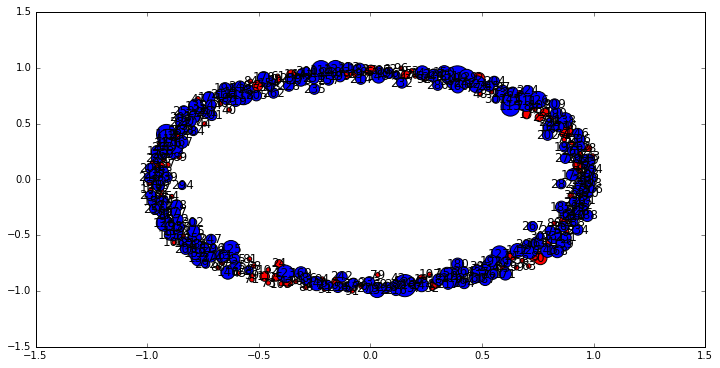

109
108


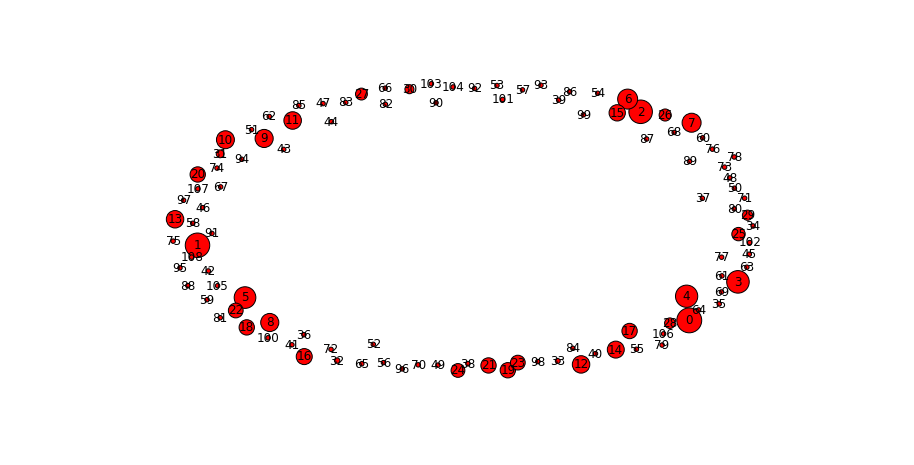

In [47]:
MAX_ERR = 10

def hamming_check(alpha, beta, max_err = MAX_ERR):
	if len(alpha) != len(beta): 
		print("!!!!")
	err = 0
	for a, b in zip(alpha, beta):
		err += (a != b) and (a != 'N') and (b != 'N')
		if err > max_err:
			return False
	return True


def make_graph_old(sequences):
    G=nx.Graph()
    for i in range(len(sequences)):
        G.add_node(i)
    for i in range(len(sequences) - 1):
        for j in range(i, len(sequences)):
            if hamming_check(sequences[i][0], sequences[j][0]):
                G.add_edge(i, j)
    return G


def single_graph(sequences):
    node_sizes = [math.log2(x[1]) for x in sequences]
    node_sizes_min = min(node_sizes)
    node_sizes_max = max(node_sizes)
    for i in range(len(node_sizes)):
        node_sizes[i] = 20 + 600 * (node_sizes[i] - node_sizes_min) / (node_sizes_max - node_sizes_min)

    G = make_graph_old(sequences)
    print(G.number_of_nodes())
    print(G.number_of_edges())
    pos = nx.spring_layout(G, k = .25)
    nx.draw(G, pos, node_size = node_sizes)
    nx.draw_networkx_labels(G, pos)
    plt.show()


def make_graph(minors, majors):
    neis = {x: [] for x in map(lambda x: x[0], majors)}
    
    G=nx.Graph()
    for i in range(len(minors) + len(majors)):
        G.add_node(i)
    for i in range(len(minors)):
        for j in range(len(majors)):
            if hamming_check(minors[i][0], majors[j][0]):
                G.add_edge(i, len(minors) + j)
                neis[majors[j][0]].append(i)
    return G, neis


def bigraph(minors, majors):
    node_sizes = [math.log2(x[1]) for x in minors + majors]
    node_sizes_min = min(node_sizes)
    node_sizes_max = max(node_sizes)
    for i in range(len(node_sizes)):
        node_sizes[i] = 20 + 600 * (node_sizes[i] - node_sizes_min) / (node_sizes_max - node_sizes_min)

    G, neis = make_graph(minors, majors)
    print(G.number_of_nodes())
    print(G.number_of_edges())
    pos = nx.spring_layout(G, k = .25)
    # nx.draw(G, pos, node_size = node_sizes)
    nx.draw_networkx_nodes(G, 
                           pos, 
                           nodelist=range(len(minors)), 
                           node_color="r", 
                           node_size=node_sizes[:len(minors)])
    nx.draw_networkx_nodes(G, 
                           pos, 
                           nodelist=range(len(minors), len(majors) + len(minors)), 
                           node_color="b", 
                           node_size = node_sizes[len(minors) : len(majors) + len(minors)])
    nx.draw_networkx_edges(G, pos)
    nx.draw_networkx_labels(G, pos)
    plt.show()


bigraph(minors, majors)
single_graph(minors)

In [48]:
pr = nx.pagerank_numpy(G, alpha = .05, personalization = {i: sequences[i][1] for i in range(len(sequences))})
for i, x in enumerate(nx.connected_components(G)):
    print(i+1, ": ", sorted(list(zip(x, [round(pr[y], 4) for y in x], [sequences[y][1] for y in x])), key = lambda x: x[1], reverse = True), sep = '')
pos = nx.spring_layout(G, k = .2)
nx.draw(G, pos, node_size = [2000 * x[1] for x in pr.items()])
nx.draw_networkx_labels(G, pos)
plt.show()

NameError: name 'sequences' is not defined